Temat: "Predykcja czasu osiągnięcia odporności zbiorowej w przypadku COVID-19 w grupie Wyszehradzkiej"

Zespół: Blanka Piekarz, Marcin Stachura

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

df = pd.read_csv('./country_vaccinations.csv', delimiter=',')

columnsToDrop = ['iso_code', 'daily_vaccinations_raw', 'source_website', 'source_name',
                 'vaccines', 'people_fully_vaccinated_per_hundred',
                 'people_vaccinated_per_hundred', 'total_vaccinations_per_hundred']

data = df.drop(columnsToDrop, 1)
data = data[data['daily_vaccinations'].notna()]

#  ---- ADD POPULATION -----
df_population = pd.read_csv("population.csv", delimiter=',', sep=',', header=2, usecols=['Country Name', '2019'])
df_population.loc[df_population['Country Name'] == 'Slovak Republic', 'Country Name'] = 'Slovakia'

for i in range(0,len(df_population)):
    data.loc[data['country'] == df_population.loc[i, 'Country Name'], 'population'] = df_population.loc[i, '2019']

#  ---- VISEGRAD STATISTICS / FILL NaN -----
visegrad_countries = ['Austria', 'Bulgaria', 'Czech Republic', 'Hungary', 'Poland', 'Slovakia']
visegrad_data = data[data['country'].isin(visegrad_countries)]
for i in range(0, len(visegrad_countries)):
    visegrad_data.loc[visegrad_data['country'] == visegrad_countries[i], 'country'] = i

visegrad_data = visegrad_data.reset_index(drop=True)

import datetime as dt
visegrad_data['date'] = pd.to_datetime(visegrad_data['date'])

date_column = visegrad_data['date'].copy()
country_column = visegrad_data['country'].copy()

visegrad_data = visegrad_data.fillna(visegrad_data.mean())
visegrad_data

C:\Users\Cinek\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,country,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations,daily_vaccinations_per_million,population
0,0,2020-12-28,2026.0,2026.0,355256.492857,1295.0,144.0,8877067.0
1,0,2020-12-29,3644.0,3644.0,355256.492857,1456.0,162.0,8877067.0
2,0,2020-12-30,4991.0,4991.0,355256.492857,1420.0,158.0,8877067.0
3,0,2020-12-31,4999.0,4999.0,355256.492857,1067.0,118.0,8877067.0
4,0,2021-01-01,5002.0,5002.0,355256.492857,854.0,95.0,8877067.0
...,...,...,...,...,...,...,...,...
520,5,2021-04-09,1117826.0,830957.0,286869.000000,15141.0,2773.0,5454073.0
521,5,2021-04-10,1139514.0,851778.0,287736.000000,16604.0,3041.0,5454073.0
522,5,2021-04-11,1160576.0,871576.0,289000.000000,19028.0,3485.0,5454073.0
523,5,2021-04-12,1181053.0,882590.0,298463.000000,21900.0,4011.0,5454073.0


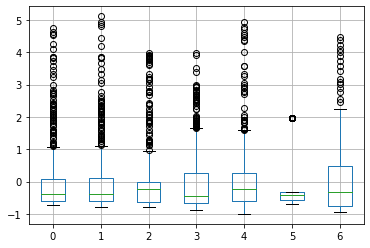

In [107]:
#  ---- STANDARDIZATION ----
visegrad_data['total_vaccinations_percentage'] = visegrad_data['total_vaccinations']/visegrad_data['population']
visegrad_data = visegrad_data.drop(['date'], 1)
visegrad_data = visegrad_data.drop(['country'], 1)


visegrad_values = visegrad_data.values
X_standard_scaler = visegrad_values - visegrad_values.mean(axis=0)
X_standard_scaler = X_standard_scaler / visegrad_values.std(axis=0)

# X_standard_scaler.hist(figsize=(30,30))
dr = pd.DataFrame(X_standard_scaler)
dr.boxplot()

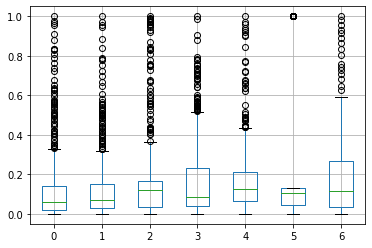

In [108]:
#  ---- STANDARDIZATION - USING SKLEARN ----
from sklearn import preprocessing

values = visegrad_data.values
min_max_scaler = preprocessing.MinMaxScaler()
data_input_scaled = min_max_scaler.fit_transform(values)
df_new = pd.DataFrame(data_input_scaled)

df_new.boxplot()

In [109]:
df_new.describe()

,0,1,2,3,4,5,6
count,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000
mean,0.131696,0.132626,0.166216,0.179627,0.168463,0.259859,0.175530
std,0.182901,0.169769,0.210591,0.206015,0.168276,0.375416,0.184220
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.020068,0.031606,0.032506,0.041091,0.065579,0.046797,0.036585
50%,0.062077,0.068769,0.118544,0.085711,0.128334,0.105268,0.114426
75%,0.143324,0.149363,0.166216,0.232318,0.213759,0.132728,0.265359
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [110]:
from sklearn.model_selection import train_test_split

X = dr.values[:,2:]
y = dr.values[:,-1:]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, shuffle=False)
x_ax = range(len(y_test))

In [111]:
from xgboost import XGBRegressor

xgb_clf = XGBRegressor(objective="reg:squarederror", n_estimators=100)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)

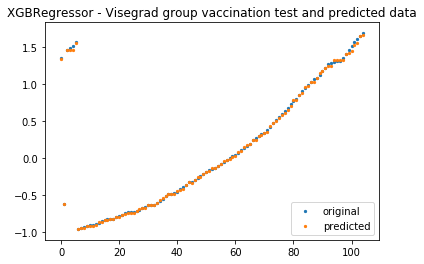

In [112]:
plt.scatter(x_ax, y_test, s=5, label="original")
plt.scatter(x_ax, y_pred_xgb, s=5, label="predicted")
plt.title("XGBRegressor - Visegrad group vaccination test and predicted data")
plt.legend()
plt.show()

In [113]:
from sklearn.svm import SVR

svr_clf = SVR()
svr_clf.fit(X_train, y_train)
y_pred_svr = svr_clf.predict(X_test)

C:\Users\Cinek\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


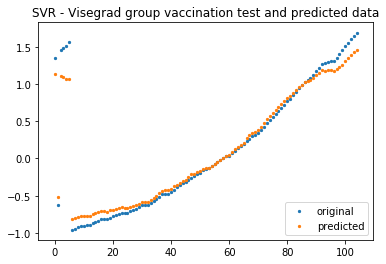

In [114]:
plt.scatter(x_ax, y_test, s=5, label="original")
plt.scatter(x_ax, y_pred_svr, s=5, label="predicted")
plt.title("SVR - Visegrad group vaccination test and predicted data")
plt.legend()
plt.show()

In [115]:
def get_r2_score(x, y):
    zx = (x-np.mean(x))/np.std(x, ddof=1)
    zy = (y-np.mean(y))/np.std(y, ddof=1)
    r = np.sum(zx*zy)/(len(x)-1)
    return r**2

y_prediction_xgb = np.reshape(y_pred_xgb, (y_pred_xgb.shape[0], -1))
y_prediction_svr = np.reshape(y_pred_svr, (y_pred_svr.shape[0], -1))

r2_score_xgb = get_r2_score(y_test, y_prediction_xgb)
r2_score_svr = get_r2_score(y_test, y_prediction_svr)

print(f'XGBRegressor score: {r2_score_xgb}')
print(f'SVR score: {r2_score_svr}')


XGBRegressor score: 0.9996979302775229
SVR score: 0.9901237880026101
